## LCPB 20-21 exercise 2

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

0. Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import time
import math

In [2]:
fname = "DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols=(0,1), unpack=True, dtype=str)
N = len(sy)

Ls = len(sx[0])


perc_train = 0.8 # I kept the same train-test ratio as in the lesson
N_train = int(N*perc_train)
N_test = N - N_train

print('Size of the sequences:   ',Ls)
print('Size of the data:        ',N)
print('Size of the training set:',N_train)
print('Size of the test set:    ',N_test)


Size of the sequences:    16
Size of the data:         3000
Size of the training set: 2400
Size of the test set:     600


In [3]:
# Just printing some datas to check it
# I noticed this isn't the same rule in the lessons, so it is unkown
for _ in range(10):
    print(sx[_],sy[_])


AAGGTCTGCCGGCCGA 1
CCTCCCTTATGGGGGA 0
TCTCTCGGAACTGTCA 0
GTTAAACGTTACATCT 0
TTAAATGCTGCTGATC 1
ATGGAACGAGACGCCG 1
AGGCCAAATGAGGATA 1
CGAGTACACTTAGGCC 0
GAAATAAATCTTATAG 0
AATGTAGATATGGAGT 0


In [4]:
# Converting the label set to int values:
print(sy[0],type(sy[0]))
y = sy.astype(int)
print(y[0],type(y[0]))

1 <class 'numpy.str_'>
1 <class 'numpy.int64'>


In [5]:
# Letters and number of letters
Q = ['A', 'C', 'G', 'T']
Nc = 4

# building the dictionary
onehc = {Q[i]: i for i in range (Nc)}

L = Ls * Nc # lenght of the input array (64)

# The following cycle will transform the input vectors (for ex.: AAGGTCTGCCGGCCGA) in a
# binary like way
#
# A = 1000
# C = 0100
# G = 0010
# T = 0001
#
#   A    A    G    G    T    C   ...
# 1000 1000 0010 0010 0001 0100
x = np.zeros((N,L))
for n in range(N): #for all the samples
    for i in range(Ls): # for every character
        x[n][i*4 + onehc[sx[n][i]]] = 1
        
print(sx[0])
print(x[0])

AAGGTCTGCCGGCCGA
[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


In [6]:
(x_train, y_train) = (x[:N_train],y[:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])

# Check the fraction of datas equal to one
print(y_train.sum() / N_train)
print(y_test.sum() / N_test)

0.24333333333333335
0.25833333333333336


1. Is the model converging with a smaller database of samples with longer sequences? By converging we mean reducing significantly the validation loss function.

In [7]:
# I MADE THE SAME TRAINING IMPLEMENTING 3 FUNCTIONS
# layer_i is an array representing a hidden layer used to create a neural network:
# layer_i = [nodes, activation, dropout_ratio]
# hidden_layers is a array of the hidden layers
layer_1 = [L/2, 'relu', 0]
layer_2 = [L/4, 'relu', .2]
hidden_layers = [layer_1,layer_2]

# optimization chosen
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov= True)

# the first function creates the Neural Network, it needs the input dimension and the array of layers
def createmodel(input_dim, hid_layers,activation = None, dropout = None):
    model = Sequential()
    
    # we add the first layer (input layer)
    model.add(Dense(input_dim, input_shape=(input_dim,)))
    
    # we add the hidden layers
    for layer in hid_layers:
        act = activation or layer[1]
        model.add(Dense(layer[0],activation=act))
        drop = dropout or layer[2]
        if drop: model.add(Dropout(drop))
    
    # we add the output layer
    model.add(Dense(1,activation='sigmoid'))
    print(model.summary())
    
    return model

# the second function trains the model created with createmodel, as a input it needs the output of createmodels
# the optimization and the arguments of model.fit() (except for shuffle)
def trainmodel(model, opt, *args, **kwargs):
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    fit = model.fit(*args, **kwargs, shuffle = True)
    '''fit = model.fit(x_train, y_train,
                    epochs = 60, batch_size = 50,
                    validation_data = (x_test,y_test),
                    shuffle = True)'''
    
    return fit

# the third function takes the output of trainmodel and plot the loss of training data and test data
def plotmodel(fit):
    for obs in ('accuracy', 'loss'):
        plt.figure(figsize=(6,4))
        plt.plot(fit.history[obs], 'r', label = obs + ' of training data')
        plt.plot(fit.history['val_'+obs], 'b--', label = obs + ' of test data')
        plt.ylabel(obs)
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        

In [8]:
#Define the model
model = createmodel(L,hidden_layers)

#Train the NN
training = trainmodel(model, opt, x_train, y_train,
          epochs=60, batch_size=50, validation_data= (x_test, y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
48/48 [==============================] - 2s 23ms/step - loss: 0.6755 - accuracy: 0.5706 - val_loss: 0.56

19/19 [==============================] - 0s 4ms/step - loss: 0.9463 - accuracy: 0.7800

Test loss: 0.9463315606117249
Test accuracy: 0.7799999713897705


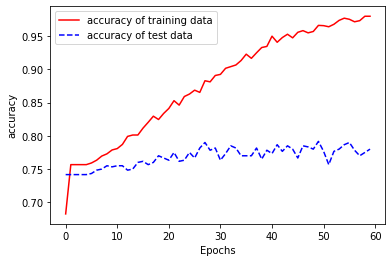

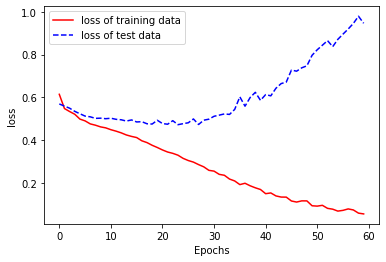

In [9]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plotmodel(training)

2. Try to improve the performance of the DNN over the validation data set by “augmenting”
the training data: For every sample there are L s -1 periodic shifts of the kind
AAACCCTTTGGG→ GAAACCCTTTGG → GGAAACCCTTTG→ etc.
We know that they can break the keys and provide a sample x’[n] with wrong label y[n]
(which is the label of original sample x[n]), but they also enlarge the number of good
samples for the DNN. Which of the two effects is prevalent?
Is the situation improving by augmenting the training data from N t real samples to L s *N t ones with this procedure?

In [10]:
#This function produces the permutations
rot = lambda A: [A[i:]+A[:i] for i in range(len(A))]

In [11]:
#Generate the augmented data
sxx = []
syy = np.zeros(len(sx)*Ls)
for i in range(len(sx)):
    sxx= np.append(sxx,rot(sx[i]))
    syy[i*Ls:(i+1)*Ls] = sy[i]
syy = syy.astype(int)

#Now we permutate the samples 
permutation = np.random.permutation(sxx.shape[0])

sxx = sxx[permutation] 
syy = syy[permutation]

In [12]:
N = len(syy)

Ls = len(sxx[0])

perc_train = 0.8 # I kept the same train-test ratio as in the lesson
N_train = int(N*perc_train)
N_test = N - N_train

print('Size of the sequences:   ',Ls)
print('Size of the data:        ',N)
print('Size of the training set:',N_train)
print('Size of the test set:    ',N_test)

Size of the sequences:    16
Size of the data:         48000
Size of the training set: 38400
Size of the test set:     9600


In [13]:
y = syy
x = np.zeros((N,L))
for n in range(N): #for all the samples
    for i in range(Ls): # for every character
        x[n][i*4 + onehc[sxx[n][i]]] = 1
        
print(sxx[0])
print(x[0])

TCCAATGCAGAGACGT
[0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


In [14]:
(x_train, y_train) = (x[:N_train],y[:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])

# Check the fraction of datas equal to one
print(y_train.sum() / N_train)
print(y_test.sum() / N_test)

0.24533854166666666
0.2503125


In [15]:
#Define the model
model = createmodel(L,hidden_layers)

#Train the NN
training = trainmodel(model, opt, x_train, y_train,
          epochs=60, batch_size=50, validation_data= (x_test, y_test))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
768/768 [==============================] - 5s 5ms/step - loss: 0.5593 - accuracy: 0.7252 - val_loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.2634 - accuracy: 0.9044

Test loss: 0.2633602023124695
Test accuracy: 0.9043750166893005


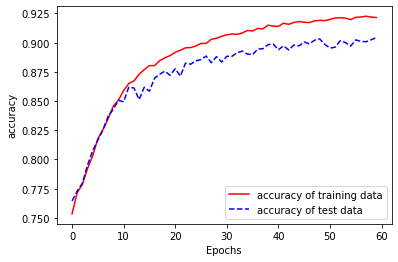

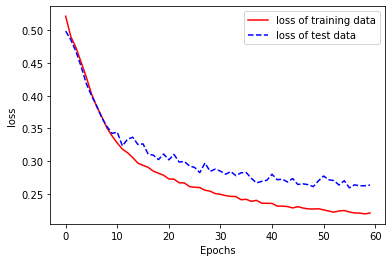

In [16]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plotmodel(training)

300/300 [==============================] - 1s 3ms/step - loss: 0.2634 - accuracy: 0.9044

Test loss: 0.2633602023124695
Test accuracy: 0.9043750166893005


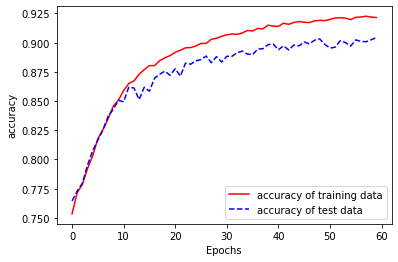

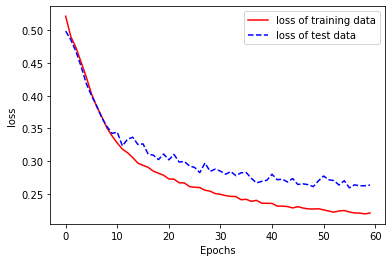

In [17]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plotmodel(training)

3. Implement a “grid search” as shown in NB11 to improve one or more of the aspects or
parameters of the model. Possible tests include: different activation units (sigmoid, relu, elu,
etc.), different minimization algorithms (ADAM, RMSprop, Nesterov, etc.), different
dropouts, etc.

In [18]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, RMSprop, SGD

def compile_model(optimizer, activation = None, dropout = None, learning_rate = 0.1):
    model = createmodel(L,hidden_layers, activation = activation, dropout = dropout)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer(learning_rate = learning_rate),
                  metrics=['accuracy'])
    return model

# Using Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1,
                        batch_size = 50, 
                        verbose=1)

optimizer = [SGD,]# RMSprop, 'Adam', 'Adamax']
dropout = [0.1,]#0.3,0.5]
learning_rate = [0.01,]#0.05,0.1]
activation = ['relu',]# 'elu']
# parameters dictionary
param_grid = dict(optimizer=optimizer, activation = activation, dropout = dropout, learning_rate = learning_rate)
# Run gridsearch
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_model = grid_result.best_estimator_

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
____________________________________________________

4. See if any rescaling of data may improve the results. For instance one may use [-0.5,+0.5]
instead of [0,1] for every bit of x[n].